## Import Library

In [110]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm,skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone

import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Problem Description Import Data

In [111]:
column_name = ["MPG","Cyleinders","Displacement","Horsepower","Weight","Acceleration","Model Year","Origin"]

In [112]:
data = pd.read_csv("/content/auto-mpg.data",names = column_name,na_values="?",comment="\t",sep=" ",skipinitialspace=True)
data.head()

,MPG,Cyleinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [113]:
data = data.rename(columns = {"MPG":"target"})
data.head()

,target,Cyleinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [114]:
print("data shape",data.shape)
data.info()

data shape (398, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cyleinders    398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [115]:
data.describe()

,target,Cyleinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## Missing Value

In [116]:
print(data.isna().sum())

target          0
Cyleinders      0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [117]:
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean)

In [118]:
data.head()

,target,Cyleinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## EDA

Text(0.5, 1.0, 'Correlation btw features')

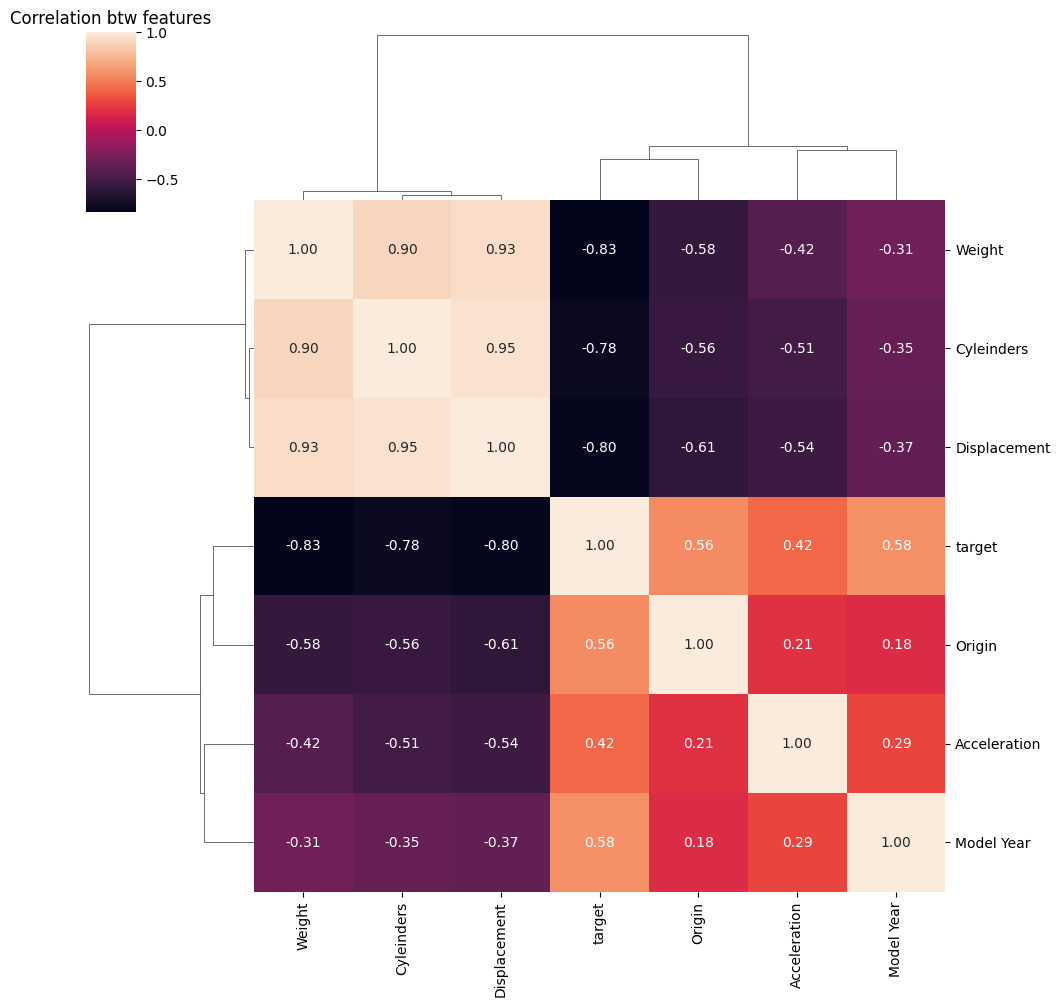

In [119]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix,annot=True,fmt=".2f")
plt.title("Correlation btw features")

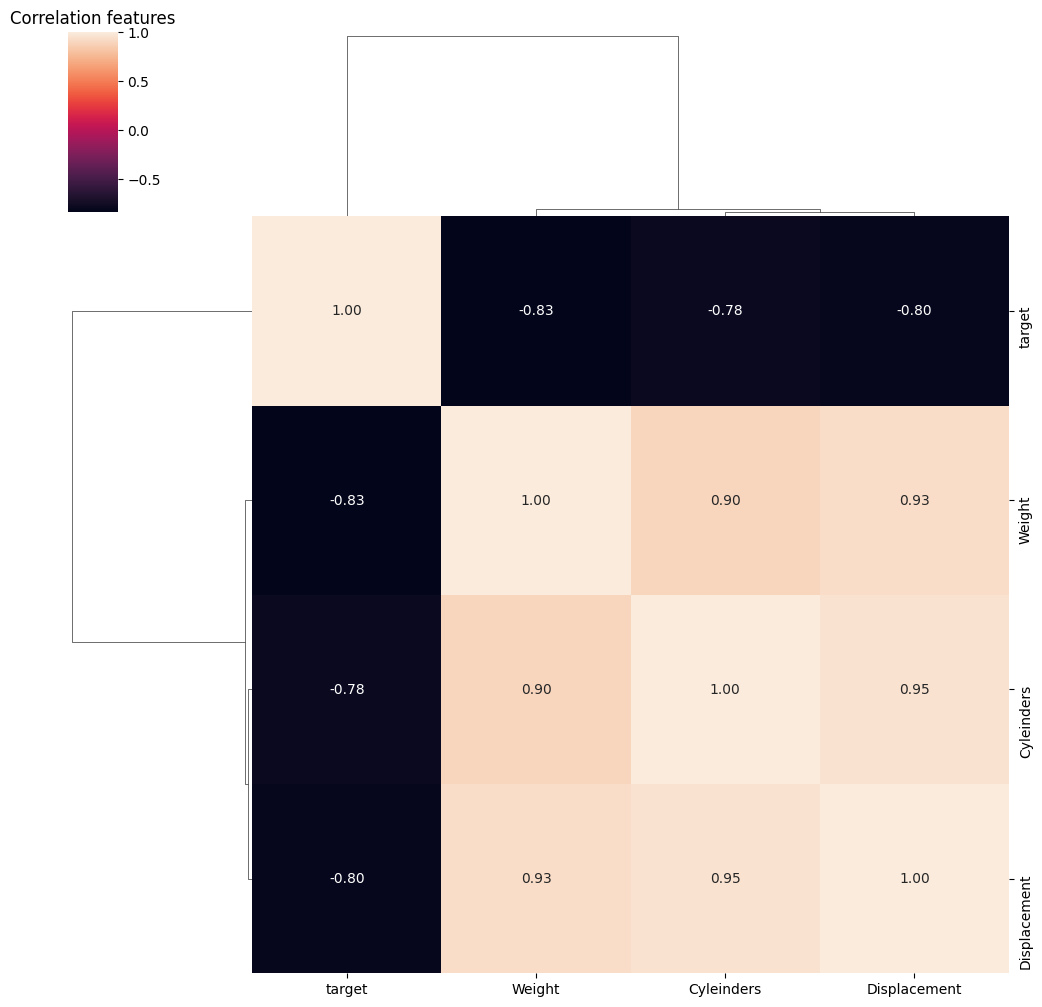

In [120]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"])>threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(),annot=True,fmt=".2f")
plt.title("Correlation features")
plt.show()

multicollinearity

<function matplotlib.pyplot.show(close=None, block=None)>

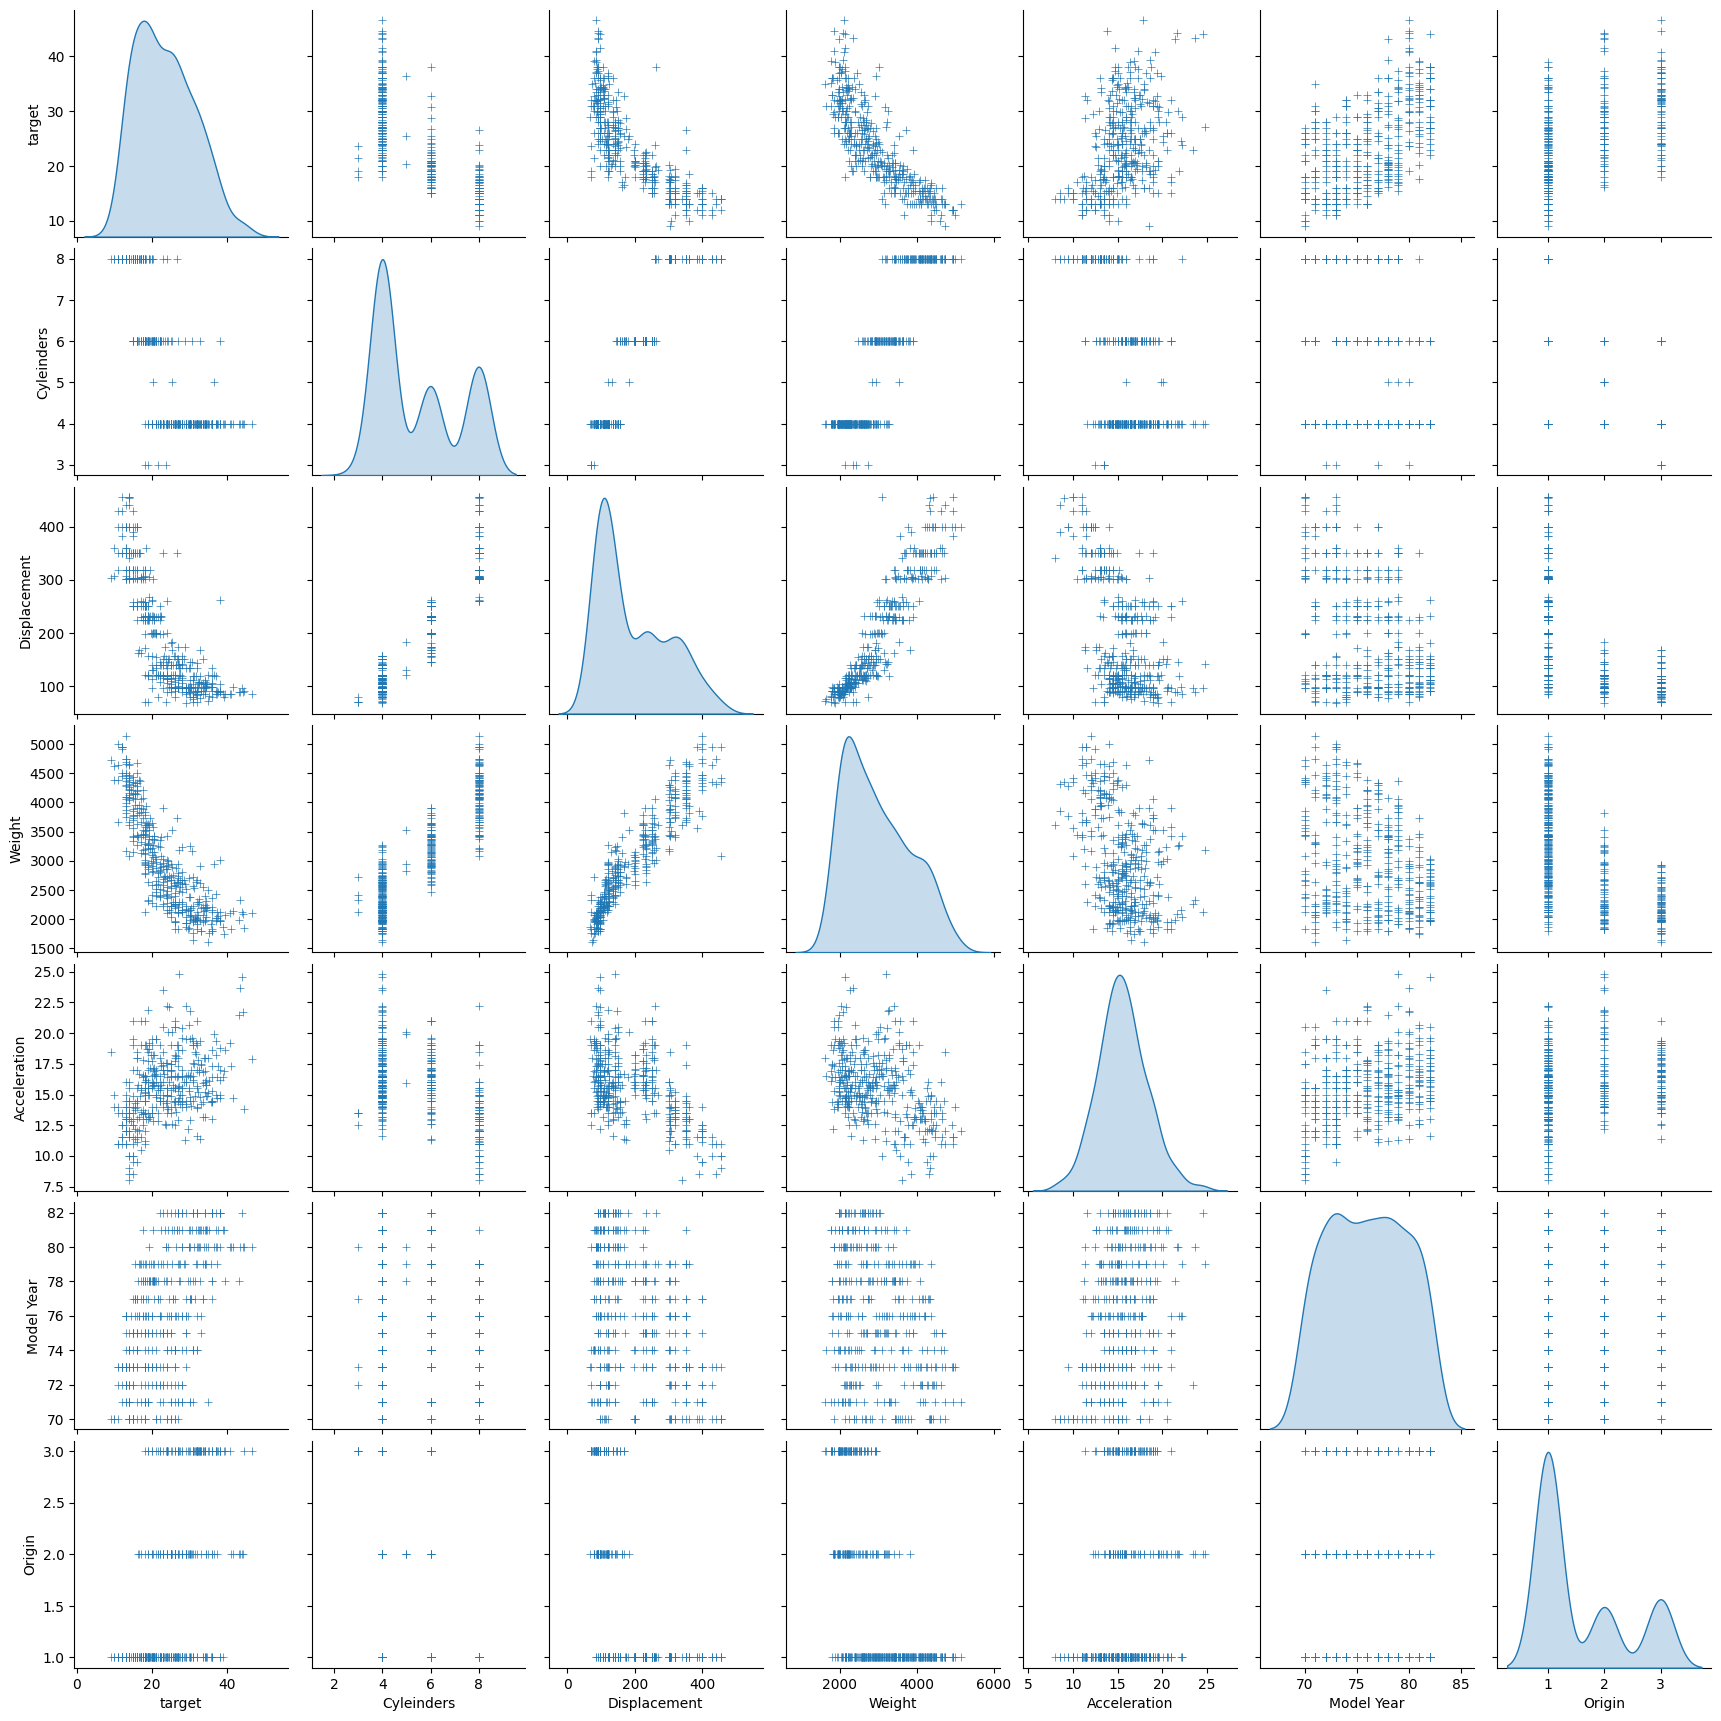

In [121]:
sns.pairplot(data,diag_kind="kde",markers="+")
plt.show

4    204
8    103
6     84
3      4
5      3
Name: Cyleinders, dtype: int64


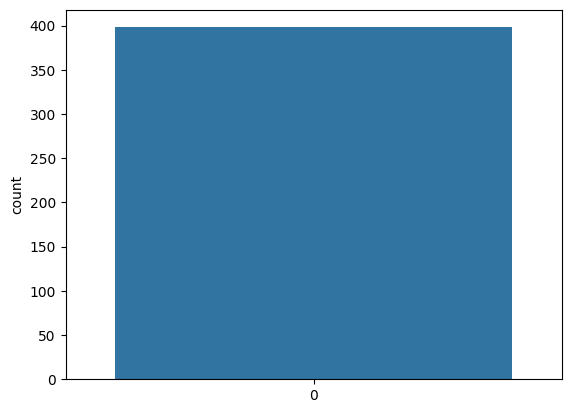

In [122]:
plt.figure()
sns.countplot(data["Cyleinders"])
print(data["Cyleinders"].value_counts())

1    249
3     79
2     70
Name: Origin, dtype: int64


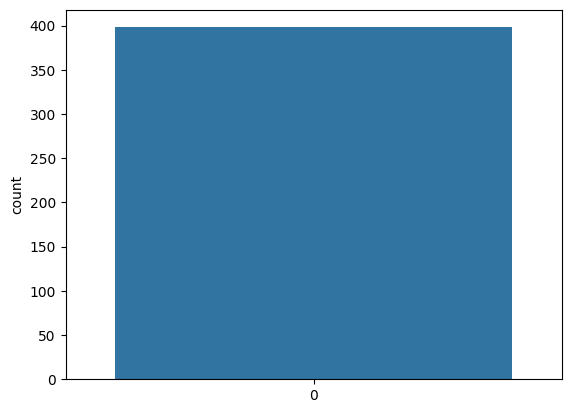

In [123]:
plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())

## Outlier

In [124]:
thr = 3
accelaration_desc = data["Acceleration"].describe()
q3_acc = accelaration_desc[6]
q1_acc = accelaration_desc[4]
IQR_acc = q3_acc - q1_acc
top_limit_acc = q3_acc + thr*IQR_acc
bot_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bot_limit_acc < data["Acceleration"]
filter_acc_top = data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top
data = data[filter_acc]

## Feature Eng.

<Axes: xlabel='target', ylabel='Density'>

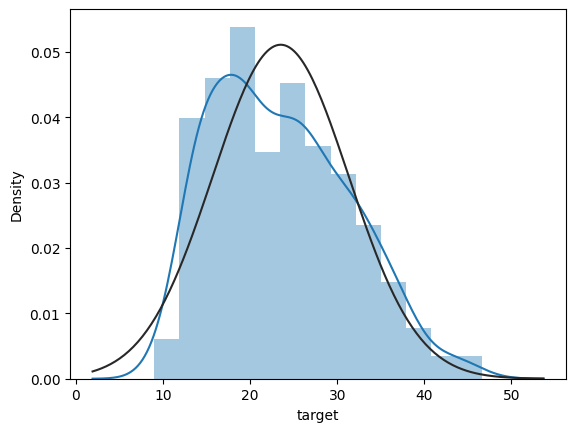

In [125]:
# Skewness

# target depent variable
sns.distplot(data.target,fit=norm)

In [126]:
(mu , sigma) = norm.fit(data["target"])
print("mu:{},sigma:{}".format(mu,sigma))

mu:23.514572864321607,sigma:7.806159061274433


<function matplotlib.pyplot.show(close=None, block=None)>

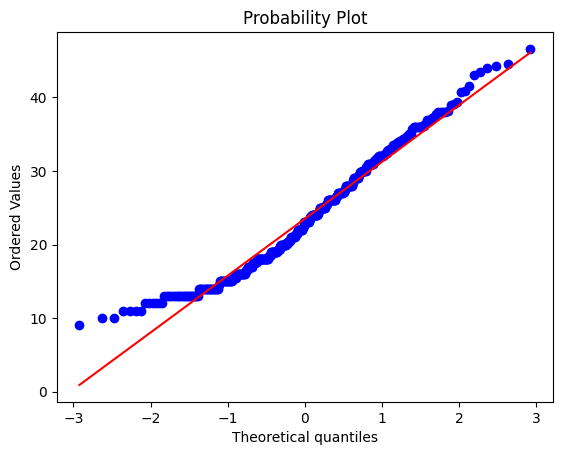

In [127]:
# qq plot
plt.figure()
stats.probplot(data["target"],plot=plt)
plt.show

<Axes: xlabel='target', ylabel='Density'>

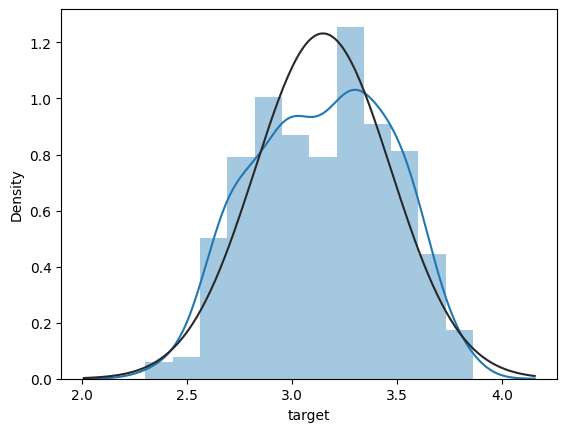

In [128]:
data["target"] = np.log1p(data["target"])
plt.figure()
sns.distplot(data.target,fit=norm)

<function matplotlib.pyplot.show(close=None, block=None)>

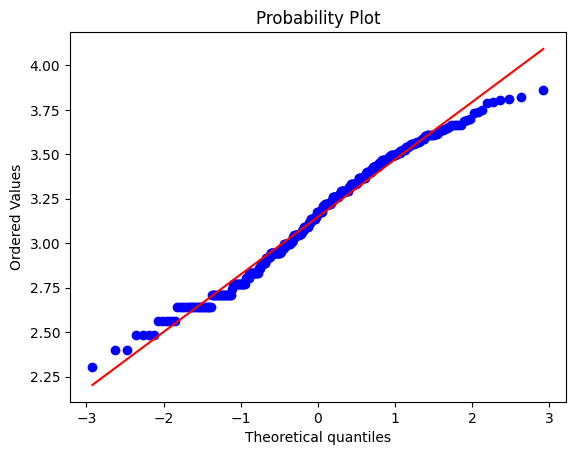

In [129]:
# qq plot
plt.figure()
stats.probplot(data["target"],plot=plt)
plt.show

In [136]:
# Feature-independent variable
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame(skewed_feats,columns= ["skewed"])
# Box Cox Transformation

TypeError: ignored

In [137]:
# one-hot encoding
data["Cyleinders"] = data["Cyleinders"].astype(str)
data["Origin"] = data["Origin"].astype(str)
data= pd.get_dummies(data)

In [138]:
data.head()

,target,Displacement,Weight,Acceleration,Model Year,Cyleinders_3,Cyleinders_4,Cyleinders_5,Cyleinders_6,Cyleinders_8,...,Horsepower_62.0,Horsepower_132.0,Horsepower_84.0,Horsepower_64.0,Horsepower_74.0,Horsepower_116.0,Horsepower_82.0,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,3504.0,12.0,70,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,2.772589,350.0,3693.0,11.5,70,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,2.944439,318.0,3436.0,11.0,70,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,2.833213,304.0,3433.0,12.0,70,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,2.890372,302.0,3449.0,10.5,70,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.info()

In [140]:
data.describe()

,target,Displacement,Weight,Acceleration,Model Year,Cyleinders_3,Cyleinders_4,Cyleinders_5,Cyleinders_6,Cyleinders_8,...,Horsepower_62.0,Horsepower_132.0,Horsepower_84.0,Horsepower_64.0,Horsepower_74.0,Horsepower_116.0,Horsepower_82.0,Origin_1,Origin_2,Origin_3
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,3.147830,193.425879,2970.424623,15.568090,76.010050,0.010050,0.512563,0.007538,0.211055,0.258794,...,0.005025,0.002513,0.015075,0.002513,0.007538,0.002513,0.002513,0.625628,0.175879,0.198492
std,0.324167,104.269838,846.841774,2.757689,3.697627,0.099871,0.500471,0.086601,0.408571,0.438523,...,0.070799,0.050125,0.122006,0.050125,0.086601,0.050125,0.050125,0.484569,0.381197,0.399367
min,2.302585,68.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.917771,104.250000,2223.750000,13.825000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.178054,148.500000,2803.500000,15.500000,76.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.401197,262.000000,3608.000000,17.175000,79.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.862833,455.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split-Stand

In [141]:
# Split
x = data.drop(["target"],axis=1)
y = data.target

In [142]:
test_size = 0.9
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=test_size,random_state=42)

In [143]:
# Standardization
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [144]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
print("Lr coef:",lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("--------------------------------------")
print("Linear Regression MSE: ",mse)

Lr coef: [-4.40949750e-01 -1.19223983e-02 -2.30035368e-01  2.83683969e-01
 -3.13275269e-01  8.53159968e-02  2.43555176e-15  1.57906275e-01
  7.00529973e-02 -7.90041436e-02 -3.99680289e-15 -1.87370152e-03
  7.40812444e-02 -3.32893435e-15 -6.06806272e-15 -4.30211422e-15
 -2.66453526e-15  4.02455846e-15  7.11236625e-16  5.35682609e-15
 -5.68173785e-01 -2.87923557e-01 -1.44328993e-15  1.61498840e-01
  3.38373266e-01  2.49347477e-01  3.17555833e-02 -1.39471767e-15
  4.71844785e-16 -2.83106871e-15 -9.02056208e-16  1.48347469e-01
  1.08018056e-01  1.61786441e-01 -1.27675648e-15  2.02615702e-15
 -2.12277408e-02  3.18072432e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.60530492e-01
  0.00000000e+00  1.57414526e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.18534325e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.07581868e-01
  0.00000000e+00

## Ridge (L2) Regression,Regularization




Ridge Coef:  [-0.13302211 -0.13546597 -0.02665641  0.1500858  -0.07716696  0.13603108
  0.         -0.0057108  -0.05315332 -0.12258599  0.          0.01874041
  0.11341517  0.          0.          0.          0.          0.
  0.          0.         -0.2218092  -0.10198129  0.          0.05371632
 -0.03995799  0.04837906  0.00702813  0.          0.          0.
  0.          0.11774876  0.0473064   0.02114808  0.          0.
 -0.03873092  0.03855702  0.          0.          0.          0.
  0.          0.16546478  0.         -0.00358852  0.          0.
  0.          0.          0.         -0.03012363  0.          0.
  0.          0.          0.          0.          0.         -0.08237853
  0.          0.          0.0308998   0.          0.          0.
  0.          0.          0.          0.          0.         -0.0552747
  0.         -0.20071052  0.          0.          0.          0.00613165
  0.          0.          0.          0.          0.06996984  0.
  0.          0.          0.  

Text(0.5, 1.0, 'Ridge')

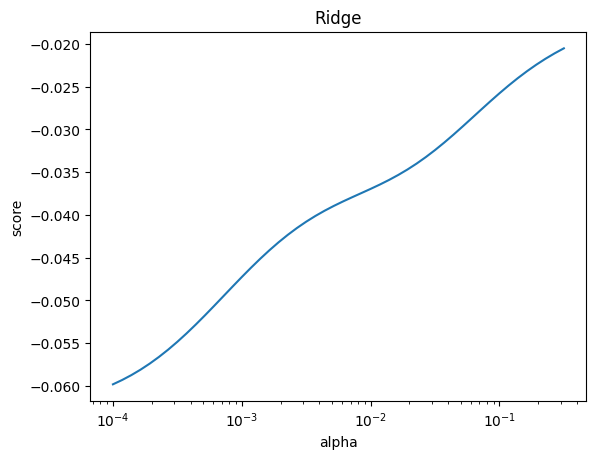

In [145]:
ridge = Ridge(random_state=42,max_iter=10000)
alphas = np.logspace(-4,-0.5)

tuned_parameters = [{"alpha":alphas}]
n_folds = 5

clf = GridSearchCV(ridge,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ",clf.best_estimator_.coef_)

ridge=clf.best_estimator_

print("Ridge Best Estimator: ",ridge)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Ridge MSE: ",mse)
print("----------------------------------------------------")

plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")


## Lasso (L1) Regression,Regularization




Lasso Coef:  [-0.0927865  -0.20656826  0.          0.14449068 -0.          0.11486537
  0.          0.         -0.         -0.07044425  0.          0.
  0.03246686  0.          0.          0.          0.          0.
  0.          0.         -0.16280854 -0.09892069  0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.01275335  0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.0245063   0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.01379175
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.09355761  0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         

Text(0.5, 1.0, 'Lasso')

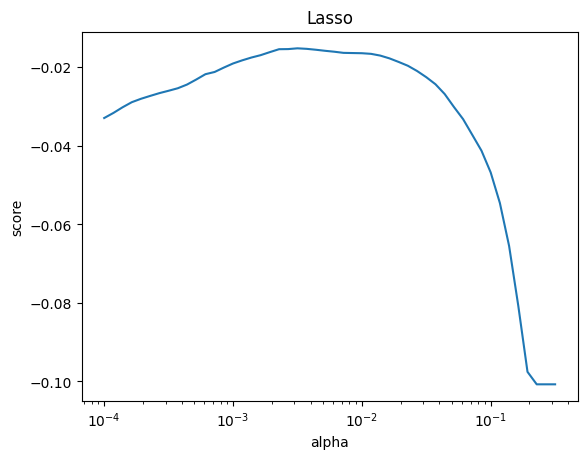

In [146]:
lasso = Lasso(random_state=42,max_iter=10000)
alphas = np.logspace(-4,-0.5)

tuned_parameters = [{"alpha":alphas}]
n_folds = 5

clf = GridSearchCV(lasso,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso Coef: ",clf.best_estimator_.coef_)

lasso=clf.best_estimator_

print("Lasso Best Estimator: ",lasso)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Lasso MSE: ",mse)
print("----------------------------------------------------")

plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

## ElasticNet Regression,Regularization

In [147]:
parametersGrid = {"alpha":alphas,
                  "l1_ratio": np.arange(0.0,1.0,0.05)}

eNet = ElasticNet(random_state=42,max_iter=10000)
clf = GridSearchCV(eNet,tuned_parameters,cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(X_train,Y_train)

print("ElasticNet Coef: ",clf.best_estimator_.coef_)

eNet = clf.best_estimator_

print("ElasticNet Best Estimator:",eNet)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE",mse)


ElasticNet Coef:  [-0.09565297 -0.20328092  0.00073211  0.1432249  -0.          0.11389503
  0.          0.         -0.         -0.06672517  0.          0.
  0.03235031  0.          0.          0.          0.          0.
  0.          0.         -0.14733045 -0.09633231  0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.01806927  0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.02711871  0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.01502462
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.08666671  0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.    

## XGBoost

In [148]:
parametersGrid = {"nthread":[4],
                  "objective":["reg:linear"],
                  "learning_rate":[.03,0.05,.07],
                  "max_depth":[5,6,7],
                  "min_child_weight":[4],
                  "silent":[1],
                  "subsample":[0.7],
                  "colsample_bytree":[0.7],
                  "n_estimators":[500,1000]}

model_xgb = clf.best_estimator_
model_xgb = xgb.XGBRegressor()
clf = GridSearchCV(model_xgb,parametersGrid,cv=n_folds,scoring="neg_mean_squared_error",refit=True,n_jobs=-1)
clf.fit(X_train,Y_train)
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

XGBRegressor MSE:  0.017976848923939144


## Averaging Models

In [150]:
class AveragingModels():
  def __init__(self,models):
    self.models=models

  def fit(self,X,y):
    self.models_=[clone(x) for x in self.models]


    for model in self.models_:
      model.fit(X,y)

    return

  def predict(self,X):
    predictions = np.column_stack([model.predict(X) for model in self.models_])
    return np.mean(predictions, axis=1)

In [151]:
averaged_models = AveragingModels(models = (model_xgb,lasso))
averaged_models.fit(X_train,Y_train)

In [152]:
y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Avaraged Models MSE: ",mse)

Avaraged Models MSE:  0.015444302268911896
